In [1]:
import pandas as pd
import os
import random
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt 

from transformers import BertModel, BertTokenizer 
import torch

/Users/sachichitre/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#import data
mammals = pd.read_excel('./data/promptListMammal.xlsx')
reptiles = pd.read_excel('./data/promptListReptile.xlsx')
birds = pd.read_excel('./data/promptListBird.xlsx')
bugs = pd.read_excel('./data/promptListBugs.xlsx')
fish = pd.read_excel('./data/promptListFish.xlsx')
 
#print(fish)

In [3]:
# Picking 15 random prompts from each dataset
# reptiles_15 = reptiles.sample(n=15, random_state=0)
bugs_15 = bugs.sample(n=15, random_state=0)
list_of_strings = bugs_15[0].astype(str).tolist()

# Print the list of strings
print(list_of_strings)
# mam = mammals_15.to_string(index=False)
# mammals_sampled = mammals.sample(n=10, random_state=0)
# mammals_list = mammals_sampled.squeeze().toList()
# fish_15 = fish.sample(n=15, random_state=0)
# bugs_15 = bugs.sample(n=15, random_state=0)
# birds_15 = birds.sample(n=15, random_state=0)
print(bugs_15)
type(bugs_15)
# type(mammals_list)

['Is a bagworm a bug?', 'Is a roseau cane scale a bug?', 'Is a pea leafminer a bug?', 'Is a sugarcane lace bug a bug?', 'Is a guava moth a bug?', 'Is a pitless pinhole borer a bug?', 'Is a clover head caterpillar a bug?', 'Is a sixspotted mite a bug?', 'Is a speckled green fruitworm a bug?', 'Is a kou leafworm a bug?', 'Is a mint aphid a bug?', 'Is a crypt gall wasp a bug?', 'Is a rice delphacid a bug?', 'Is a firtree borer a bug?', 'Is a oriental fruit fly a bug?']
                                         0
124                    Is a bagworm a bug?
1692         Is a roseau cane scale a bug?
1431             Is a pea leafminer a bug?
1969        Is a sugarcane lace bug a bug?
933                 Is a guava moth a bug?
1521     Is a pitless pinhole borer a bug?
486    Is a clover head caterpillar a bug?
1781           Is a sixspotted mite a bug?
1869  Is a speckled green fruitworm a bug?
1083              Is a kou leafworm a bug?
1259                Is a mint aphid a bug?
582          

pandas.core.frame.DataFrame

In [4]:
# Load pre-trained BertModel and BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
model = BertModel.from_pretrained('bert-base-uncased' ) 

In [5]:
# Function to find the animal name between "a" or "an" and "mammal" using vector embeddings
def find_animal_name_embeddings(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get the embeddings for the prompt
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # Shape: (num_tokens, embedding_size)
#         sentence_embedding = torch.mean(last_hidden_states, dim=1) 
#         embedding_array = sentence_embedding.detach().numpy()
    
    # Define the target words
    target_start_words = ["a", "an"]
    target_end_word = "a"

    # Initialize variables to hold the indices of the target words
    start_index = None
    end_index = None

    # Iterate through the tokens and embeddings to find the indices of the target words
    for i, token in enumerate(tokens):
        
        if token in target_start_words:
            # Check if the next token is a potential animal name
            
            for j in range(i + 1, len(tokens)):
                if tokens[j] == target_end_word:
                    start_index = i + 1
                    end_index = j
                    
                    break
#             if start_index is not None and end_index is not None:
#                 break
#     print(start_index, end_index)
     # If indices are found, calculate average embedding for the animal name
    if start_index is not None and end_index is not None:
        # Extract embeddings for the animal name
        animal_name_state = last_hidden_states[0, start_index:end_index, :]
        # Calculate mean embedding across tokens
        animal_name_embedding = animal_name_state.mean(dim=0)
        # Convert to numpy array
        animal_name_embedding_np = animal_name_embedding.detach().numpy()
        
        # Convert tokens to string
        animal_name_tokens = tokens[start_index:end_index]
        animal_name = tokenizer.convert_tokens_to_string(animal_name_tokens)
        
        return animal_name, animal_name_embedding_np
    
    # Return None if the animal name is not found
    return None, None

# Testing the function
# prompt1 = "is a brown hyena a mammal?"
# animal_name1, embeddings1 = find_animal_name_embeddings(prompt1)
# print(f"Animal name in prompt: '{animal_name1}', Embeddings shape: {embeddings1.shape}")
# print(len(embeddings1))

# prompt2 = "do you know if a platypus is a mammal?"
# animal_name2, embeddings2 = find_animal_name_embeddings(prompt2)
# print(f"Animal name in prompt: '{animal_name2}', Embeddings shape: {embeddings2.shape}")

# prompt3 = "an ostrich is a bird, but is it a mammal?"
# animal_name3, embeddings3 = find_animal_name_embeddings(prompt3)
# print(f"Animal name in prompt: '{animal_name3}', Embeddings shape: {embeddings3.shape}")


In [6]:
def getEmbedding(text):
    tokens = tokenizer(text, return_tensors='pt') 
    outputs = model(**tokens) # Transformer layers
    last_hidden_states = outputs.last_hidden_state 
    sentence_embedding = torch.mean(last_hidden_states, dim=1) 
    embedding_array = sentence_embedding.detach().numpy() 
    return embedding_array 

In [7]:
# finds the animal name token vector embeddings within prompt for mammal
vecEmbedsBugs = []
vecName = []
for vecM in list_of_strings:
    animal_name, embeddings = find_animal_name_embeddings(vecM)
    vecEmbedsBugs.append(embeddings)
    vecName.append(animal_name)

vecEmbedsBugs2 = []
for vecM2 in list_of_strings:
    prompt_embedding = getEmbedding(vecM2)
    vecEmbedsBugs2.append(prompt_embedding)
type(vecEmbedsBugs)

# Print the list of vector embeddings of animal names
#print(vecEmbedsBugs)
# print(vecEmbedsBugs2)
# print(len(vecEmbedsBugs2))

list

In [8]:
### Creating Cosine Distance Matrix ###
# print(vecEmbedsBugs2)
vecEmbedsBugs2_reshaped = [np.array(embedding).reshape(-1) for embedding in vecEmbedsBugs2]
cosineMatrix = np.zeros((len(vecEmbedsBugs), len(vecEmbedsBugs2_reshaped)))
# Calculate cosine distances and angles between each pair of embeddings
for i in range(len(vecEmbedsBugs)):
    for j in range(len(vecEmbedsBugs2_reshaped)):
        cosineMatrix[i][j] = 1 - distance.cosine(vecEmbedsBugs[i], vecEmbedsBugs2_reshaped[j])
angleMatrix = np.arccos(cosineMatrix) * 180 / np.pi

In [9]:
angleMatrix

array([[40.35173458, 48.1051801 , 44.53706098, 47.3925502 , 47.68294745,
        43.87154825, 44.68024725, 44.84389594, 41.56309583, 44.21892044,
        47.19066493, 48.35809213, 45.47960941, 45.02829588, 47.71478427],
       [56.70508856, 36.5085089 , 55.03152772, 53.44036101, 55.11240315,
        54.80323671, 54.19934425, 54.90113251, 52.24057741, 51.74195411,
        55.17712608, 54.12423667, 53.6817597 , 53.28306346, 54.14106823],
       [45.12909288, 46.1744179 , 30.53243402, 43.03723781, 44.76353452,
        37.4829165 , 36.86731234, 41.36303429, 37.47704026, 44.30382164,
        42.78485564, 45.16859854, 41.91621085, 39.95290471, 44.56775764],
       [47.79016347, 44.04153734, 42.64400168, 34.81709623, 44.17756562,
        45.79266603, 43.5003349 , 46.92951841, 42.26544061, 45.79418579,
        45.42166776, 44.27452131, 44.63396681, 46.70629538, 44.7257183 ],
       [50.88800835, 49.58888017, 48.54687463, 48.27006262, 37.93848341,
        48.13210532, 46.88705544, 49.12274998, 

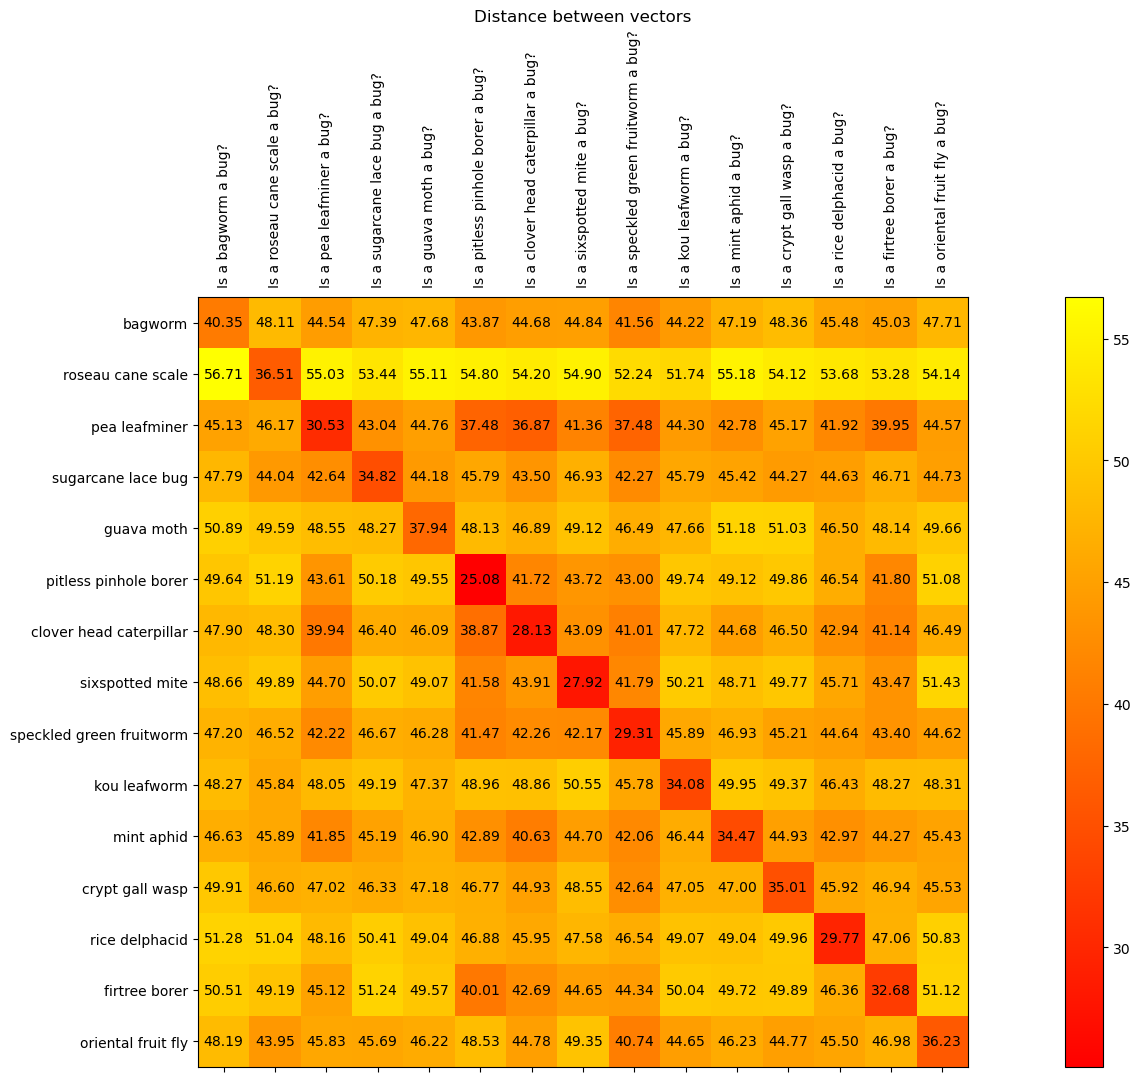

In [10]:
# Plotting Results in Heatmap
plt.figure(figsize=(25, 10)) 
plt.imshow(angleMatrix, cmap='autumn')

# Add cell values as text annotations
for i in range(len(vecEmbedsBugs)):
    for j in range(len(vecEmbedsBugs2_reshaped)):
        plt.annotate(f'{angleMatrix[i][j]:.2f}', xy=(j, i), ha='center', va='center')

plt.title("Distance between vectors") 
plt.xticks(np.arange(len(list_of_strings)), list_of_strings, rotation=90) #prompts
plt.yticks(np.arange(len(vecName)), vecName) # animal words
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()